In [50]:
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Przygotowanie danych

Polecenia z poprzednich zajęć. Kopiuj - wklej

In [51]:
rasters = rio.open("dane/rasters.vrt") 
vector = gpd.read_file("dane/proby.gpkg")
colnames = [os.path.splitext(os.path.basename(file))[0] for file in rasters.files[1:]]
coords = zip(vector.geometry.x,vector.geometry.y)
samples = [x for x in rasters.sample(coords)]
samples = gpd.GeoDataFrame(samples,columns=colnames).join(vector)

## Prosta zależność liniowa



In [52]:
from sklearn.linear_model import LinearRegression as ls
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

### Nie za dobry model bo dane nie są skalowane

Powoduje to, że współczynniki kierunkowe są bardzo małe jeżeli rzędy wielkości zmiennych wyjaśniających i wyjaśnianych są różne

In [53]:
columns = samples.columns.drop(['tempr','landuse','geometry']) # temperatura zostaje
rows = ~samples.isna().any(1) # to się nie zmieni
X = samples.loc[rows,columns]
y = samples.loc[rows,'tempr']
model = ls().fit(X,y)
pd.Series(model.coef_,index=columns) # taki trick aby sobie wyświetlić wyniki z nazwami


01_roughness      0.000471
02_green         -1.193104
03_distwaters     0.000037
04_terange       -0.028922
05_imperm         2.098370
06_highbuildup    1.631118
07_buildup        4.259273
08_road_dens      0.000011
dtype: float64

In [54]:
samples.max(numeric_only=True)

01_roughness         24.257038
02_green              0.729423
03_distwaters      6017.448242
04_terange           22.169487
05_imperm             0.917956
06_highbuildup        0.889136
07_buildup            0.502405
08_road_dens      93852.200025
tempr                15.710788
dtype: float64

### Skalowanie danych

In [55]:
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
scaled = pd.DataFrame(Xs,columns = X.columns,index=X.index)

In [56]:
model = ls().fit(Xs,y)
pd.Series(model.coef_,index=columns)


01_roughness      0.003320
02_green         -0.180810
03_distwaters     0.048612
04_terange       -0.086534
05_imperm         0.438818
06_highbuildup    0.253781
07_buildup        0.264432
08_road_dens      0.120840
dtype: float64

In [57]:
trans = PowerTransformer().fit(X)
Xt= trans.transform(X)
Xt = pd.DataFrame(Xt,columns = X.columns,index=X.index)

In [58]:
model = ls().fit(Xt,y)
pd.Series(model.coef_,index=columns)

01_roughness      0.091521
02_green         -0.325826
03_distwaters    -0.016838
04_terange       -0.099854
05_imperm         0.282773
06_highbuildup    0.329332
07_buildup        0.391641
08_road_dens      0.023761
dtype: float64

### Predykcja modelu

Poniżej powtórka z poprzednich zajeć

In [59]:
dane_r = rasters.read()
s = dane_r.shape 
flat_r = dane_r.reshape(s[0],s[1]*s[2]).T
flat_r = pd.DataFrame(flat_r,columns=X.columns)
rows_r = ~flat_r.isna().any(1)
Xtr = flat_r.loc[rows_r]

Tu jest trochę inaczej wynik to tylko jedna warstwa

In [60]:

result  = model.predict(Xtr)
ls_rf = np.full(flat_r.shape[0],np.nan)
ls_rf[rows_r] = result
ls_rf = ls_rf.T
ls_rf = ls_rf.reshape(s[1],s[2])

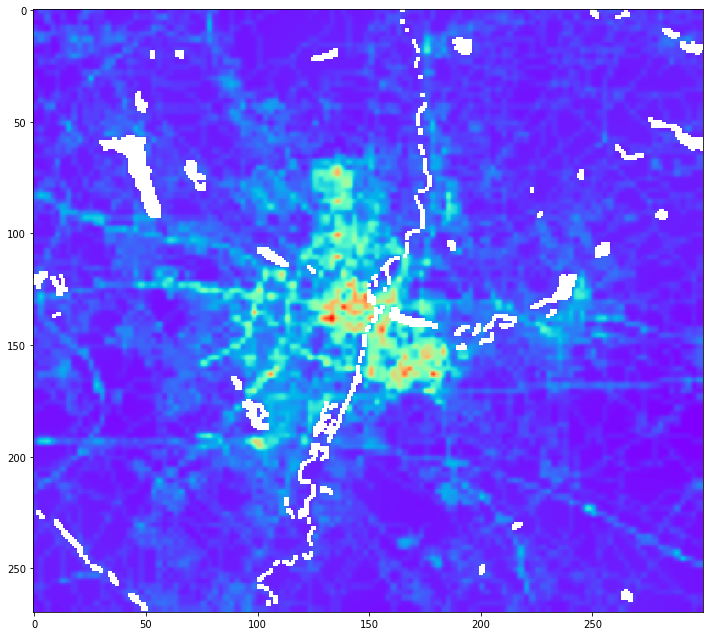

In [61]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(ls_rf,cmap="rainbow")

In [62]:
profile = rasters.profile
profile['driver'] = 'GTiff'
profile['count']=1
ls_rasters = rio.open('model_ls.tif','w', **profile)
ls_rasters.write(ls_rf.astype('float64'),1)
ls_rasters.close()

# Klasyfikacja

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [64]:
X = samples.loc[rows,columns]
y = LabelEncoder().fit_transform(samples.loc[rows,'landuse'])
model = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20)
model.fit(X,y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20)

In [65]:
result  = model.predict(Xtr)+1
dt_rf = np.zeros(flat_r.shape[0])
dt_rf[rows_r] = result
dt_rf = dt_rf.T
dt_rf = dt_rf.reshape(s[1],s[2])


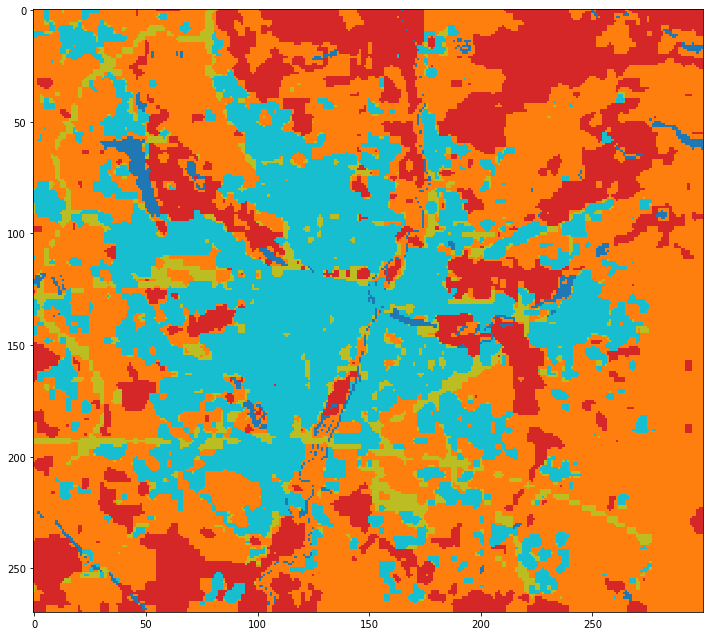

In [66]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(dt_rf,cmap="tab10",interpolation='nearest')

### Zapis wyników dla danych kategoryzowanych

In [73]:
profile = rasters.profile
profile['driver'] = 'GTiff'
profile['count']=1
profile['dtype']=np.uint8
profile['nodata']=0
ls_rasters = rio.open('model_dt.tif','w', **profile)
ls_rasters.write(ls_rf.astype(np.uint8),1)
ls_rasters.close()